# Email Spam Detection With Machine Learning
## Project by MEGHA MITTAL


### Importing Neccessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier


### Loading the dataset

In [2]:
df= pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


##### As you can see in reading the csv file,  I have given second argument named as encoding ,this encoding parameter specifies the character encoding of the file. In this case, 'ISO-8859-1' is used, which is a common encoding for text files.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


##### The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.



##### As we can see in the info of df dataframe, columns named as unmanned:2, unmanned:3, unmanned:4 are irrelevant, so we have to drop them before moving towards more preprocessing steps.

In [4]:
df.shape

(5572, 5)

##### We have 5572 rows of data, which is message and its corresponding label which can be either a ham or a spam email.

In [5]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [6]:
df.columns = ['label', 'message']

##### Let's rename the column names to more logical names as message and label for better understanding.


In [7]:
df.columns

Index(['label', 'message'], dtype='object')

In [8]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.isnull().sum()

label      0
message    0
dtype: int64

#### No missing values

In [10]:
print(df.duplicated().sum())

403


##### We have 403 emails which are duplicate of each other. So, lets remove these so that our model should not get overfitted while learning the same emails which are residing in our dataset(spam.csv)

In [11]:
df= df.drop_duplicates(keep='first')
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#####  As you can notice the argument is setted in duplicate function which is the "keep" parameter is set to 'first'. This means that when duplicate rows are found, only the first occurrence of each duplicate row will be kept, and all subsequent occurrences will be removed.

In [12]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##### Notice in our dataset, the data is in the text format, but models or neural networks understands numbers, so we have to convert our text data into number representation of them. For this task, lets use labelencoding, or you can use other also like word2vec, embeddings in the nltk library etc.

### Label Encoding

In [13]:
encoder= LabelEncoder()
df['label']= encoder.fit_transform(df['label'])
df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [14]:
df['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

#### We have 4516 ham emails and rest 653 are spam emails

# Exploratory Data Analysis


([<matplotlib.patches.Wedge at 0x30002ee90>,
 [Text(-0.42519443516002475, -1.0144997251399075, 'ham'),
  Text(0.42519434017570373, 1.014499764949479, 'spam')],
 [Text(-0.23192423736001347, -0.5533634864399495, '87.4%'),
  Text(0.2319241855503838, 0.5533635081542612, '12.6%')])

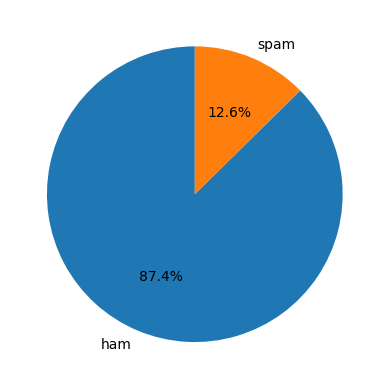

In [15]:
plt.pie(df['label'].value_counts(), labels=['ham', 'spam'], autopct='%1.1f%%', startangle=90)

#### As you can easily observe from the pie chart that , there is class imbalance problem , i.e we ham more data for ham emails then for the spam emails. This problem can leads us to overfitting. 

In [16]:
from imblearn.over_sampling import RandomOverSampler

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler()

# Resample the dataset
X_resampled, y_resampled = oversampler.fit_resample(df['message'].values.reshape(-1, 1), df['label'])

# Create a new balanced dataframe
df_balanced = pd.DataFrame({'message': X_resampled.flatten(), 'label': y_resampled})

# Check the class distribution
df_balanced['label'].value_counts()

label
0    4516
1    4516
Name: count, dtype: int64

In [17]:
df_balanced


,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
9027,Urgent Please call 09066612661 from landline. ...,1
9028,You have an important customer service announc...,1
9029,"Hi babe its Jordan, how r u? Im home from abro...",1
9030,Free entry to the gr8prizes wkly comp 4 a chan...,1


#### Now we have balanced dataset

In [20]:
df_balanced['number_characters'] = df_balanced['message'].apply(len)
df_balanced.head()

,message,label,number_characters
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


In [43]:
# import nltk
# nltk.download('punkt', download_dir='/punkt')
# import os
# nltk.data.path.append('/punkt')
# df_balanced['number_words'] = df_balanced['message'].apply(lambda x: len(nltk.word_tokenize(x)))


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/megha/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/punkt'
    - '/punkt'
    - ''
**********************************************************************


In [45]:
import nltk
nltk.download('punkt')

df_balanced['number_words'] = df_balanced['message'].apply(lambda x: len(nltk.word_tokenize(x)))

print(df_balanced)


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/megha/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/punkt'
    - '/punkt'
    - ''
**********************************************************************
